# Mansa Kanedama Data Science
#### Oscar Gilg

#### Intro

This notebook will experiment with 3 types of models to predict expense given 3 months of history:

    - Linear Regression (and Lasso, Ridge)
    - XGBoost
    - Feed-forward neural networks
    
Using the insights from the data exploration, we now have a set of features to train on. We may want to refine this set of features as we experiment with different models.

In [1]:
cd ..

C:\Users\oscar\PycharmProjects\kanedama


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [3]:
transactions = pd.read_csv(os.path.join('datascience','data', 'transactions.csv'))
transactions.date = pd.to_datetime(transactions.date, format="%Y/%m/%d")
accounts = pd.read_csv(os.path.join('datascience', 'data', 'accounts.csv'))
users = pd.read_csv(os.path.join('datascience', 'data', 'users.csv'))
users.update_date = pd.to_datetime(users.update_date, format="%Y/%m/%d")

In [4]:
from src.user_data.User import User
from src.user_data.UserDataExtractor import UserDataExtractor
from src.user_data.utils import get_job_type

### Transforming the data into trainable format

In [5]:
def get_naf_code(user_id):
    return users.loc[users['id'] == user_id]['business_NAF_code'].values[0]

In [6]:
months_back = 3

In [7]:
def get_train_vectors(start_date, user_data):
    past_data = user_data.construct_past_data(start_date, months_back, user_data.filled_history)
    next_income = user_data.calculate_income(user_data.filled_history[start_date: start_date+np.timedelta64(30,'D')])
    next_expense = user_data.calculate_expense(user_data.filled_history[start_date: start_date+np.timedelta64(30,'D')])

    return past_data, next_income, next_expense

In [8]:
def build_train_data(user, X, Y_inc, Y_exp):
    user_data = UserDataExtractor(u)
    start_train_date = user_data.start_date + np.timedelta64((months_back)*30, 'D')
    while start_train_date < user_data.end_date-np.timedelta64(31,'D'):
        past_data, next_income, next_expense  = get_train_vectors(start_train_date, user_data)
        X = X.append(pd.concat([past_data, user.info], axis=1))
        Y_exp.append(next_expense)
        Y_inc.append(next_income)
        start_train_date = start_train_date + np.timedelta64(30,'D')
    return X, Y_inc, Y_exp

In [67]:
X = pd.DataFrame()
Y_inc = []
Y_exp = []
for user_id in range(343):
    u = User(user_id, accounts, transactions, get_naf_code(user_id))
    # only select users with sufficient history, plots will show up blank
    if u.get_history_length() < (months_back)*30 or len(u.account_history) < 20:
        continue
    X,Y_inc, Y_exp = build_train_data(u, X, Y_inc, Y_exp)
    if user_id%50 == 49:
        print(user_id)


49
99
149
199
299


## Encoders

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
label_encode_cols = ['naf_code', 'job_type', 'last_letter_naf']

In [12]:
naf_enc = LabelEncoder().fit(X['naf_code'])
X['naf_code'] = naf_enc.transform(X['naf_code'])
job_type_enc = LabelEncoder().fit(X['job_type'])
X['job_type'] = job_type_enc.transform(X['job_type'])
last_letter_enc = LabelEncoder().fit(X['last_letter_naf'])
X['last_letter_naf'] = last_letter_enc.transform(X['last_letter_naf'])

In [13]:
pickle.dump(naf_enc, open('naf_enc.pickle', 'wb'))
pickle.dump(job_type_enc, open('job_type_enc.pickle', 'wb'))
pickle.dump(last_letter_enc, open('last_letter_enc.pickle', 'wb'))

In [14]:
naf_encoder = LabelEncoder().fit(pd.DataFrame(users['business_NAF_code'].unique()))

C:\Users\oscar\anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
job_types = [get_job_type(code) for code in users['business_NAF_code'].unique()]
unique_job_types = list(set(job_types))
job_type_encoder = LabelEncoder().fit(pd.DataFrame(unique_job_types))

## Modeling

In [16]:
def evaluate_model(model, X_val, y_val):
    print("RMSE - Val: ", np.sqrt(mean_squared_error(y_val, model.predict(X_val))))
    print("R^2 - Val: ", r2_score(model.predict(X_val), y_val))

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

Separate train, validation and test sets. The small amount of data means we only take 20% for each.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_exp, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

## Linear Regression 

My first step is always to start with a linear model with some regularisation.

In [51]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [52]:
lr = Ridge(fit_intercept=True, alpha=0.005, max_iter=15000)
lr = lr.fit(X_train, y_train)


In [53]:
evaluate_model(lr, X_val, y_val)

RMSE - Val:  3470.713707990297
R^2 - Val:  0.5909731694686724


The R^2 value goes up to 0.7 with Ridge and 0.66 with Lasso. As this is human behaviour, an R^2 higher than 0.7 is unlikely to be possible so this is quite good. It is unlikely that the models are overfitting too much because of how simple they are and how much regularisation is chosen (1-10).

In [54]:
params = {
    'alpha':[0.001, 0.005, 0.01,0.05, 0.1, 1, 5, 10],
    'fit_intercept' : [True, False],
    'normalize': [True, False]
}

In [30]:
lr=Ridge(max_iter=10000)
lr_grid = GridSearchCV(lr, param_grid=params, verbose=3, cv=5, scoring='r2', n_jobs=4)
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=Ridge(max_iter=10000), n_jobs=4,
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='r2', verbose=3)

In [31]:
lr_grid.best_params_

{'alpha': 0.005, 'fit_intercept': True, 'normalize': True}

In [32]:
lr_grid.best_score_

0.6139923806096733

In [55]:
pd.DataFrame(lr.coef_, index=X.columns)

,0
income_3,0.050995
expense_3,0.003227
agg_3,0.101745
month_std_3,-0.741748
month_end_bal_3,0.358780
income_2,-0.073503
expense_2,0.269162
agg_2,0.292366
month_std_2,0.673421
month_end_bal_2,0.028852


The coefficients are hard to compare because the features are not normalized. Overall, we get:

- negative coefficients for income
- positive coefficients for expense
- positive coeffs for aggregate

Which is sensible

### XGBoost

On top of its good performance, XGBoost can give us an insight into feature importances

In [56]:
import xgboost as xgb
from xgboost import plot_importance

In [58]:
xg = xgb.XGBRegressor(**best_params, objective ='reg:squarederror')
xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
evaluate_model(xg, X_val, y_val)

RMSE - Val:  3597.283537931519
R^2 - Val:  0.560099184263362


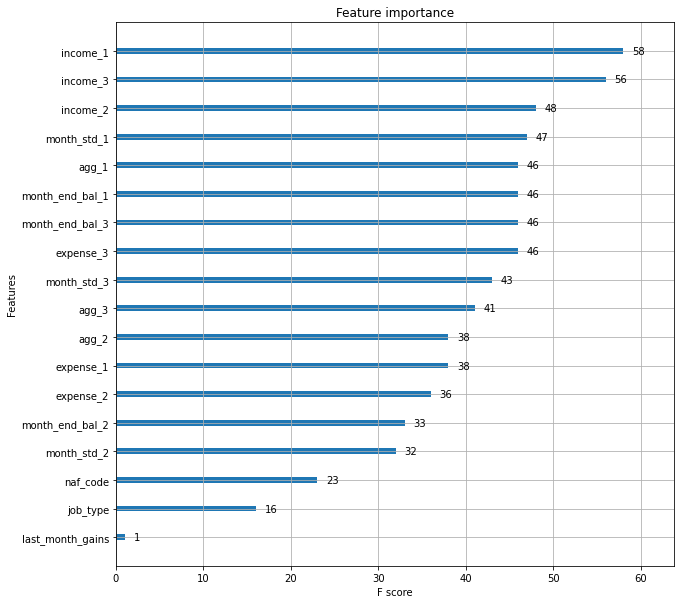

In [60]:
fig,ax = plt.subplots(figsize=(10,10))
plot_importance(xg.get_booster(),ax=ax)
plt.show()

Income is what has the greatest importance, which is reassuring.

The encoded features related to the naf code do not have much explanatory power according to this model. The number of features is quite low, so we will keep them, but with a label encoder for the last letter to avoid introducing 5 potentially unhelpful features. Dropping the feature could also be a good idea after more testing.

In [ ]:
params = {
        'min_child_weight': [10],
        'max_depth': [6, 7],
        'n_estimators' : [10, 20, 50],
        'learning_rate' : [0.1, 0.3, 0.5],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'eta':[0.01, 0.1, 0.5],
        'subsample': [0.7, 0.8, 1.0],
    
        }

In [ ]:
xg = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror')


In [ ]:
xg_grid = GridSearchCV(xg, param_grid=params, verbose=3, cv=4, scoring='r2', n_jobs=4)

In [ ]:
xg_grid.fit(X_train, y_train)

In [ ]:
xg_grid.best_params_

In [57]:
best_params = {'colsample_bytree': 0.8,
 'eta': 0.01,
 'learning_rate': 0.5,
 'max_depth': 4,
 'n_estimators': 50,
 'subsample': 1.0}

In [ ]:
xg_grid.best_score_

This does no go higher than 0.55 in my runs

In [ ]:
xg = xg_grid.best_estimator_

The performance of XGBoost was not as good as linear regression so it isn't worth investigating this model further.

## Neural Network

Finally, neural networks with a small number of layer might work in this case, due to the fact that this is probably a somewhat non-linear regression problem

In [61]:
from sklearn.neural_network import MLPRegressor

In [62]:
best_params = {'activation': 'relu',
 'alpha': 2.0,
 'beta_1': 0.9,
 'beta_2': 0.95,
 'early_stopping': True,
 'hidden_layer_sizes': (128, 128),
 'learning_rate': 'adaptive',
 'momentum': 0.1,
 'solver': 'adam'}

In [63]:
nn = MLPRegressor(**best_params, random_state=9, max_iter=5000)
nn.fit(X_train, y_train)

MLPRegressor(alpha=2.0, beta_2=0.95, early_stopping=True,
             hidden_layer_sizes=(128, 128), learning_rate='adaptive',
             max_iter=5000, momentum=0.1, random_state=9)

In [64]:
evaluate_model(nn, X_val, y_val)

RMSE - Val:  3272.6690582570777
R^2 - Val:  0.5866241195402752


R^2 value reaches 0.66 on some random_states but overall is around 0.58. While promising, this is not as good as the Linear Regression model.

In [ ]:
params = {
    'hidden_layer_sizes': [(128,128), (128, 128, 32), (128, 128, 64)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [1.0, 1.5, 2.0],
    'learning_rate': ['adaptive'],
    'momentum' : [0, 0.1],
    'early_stopping': [True],
    'beta_1': [0.9],
    'beta_2': [0.95]
}

In [ ]:
nn = MLPRegressor(random_state=3, max_iter=5000)

In [ ]:
nn_grid = GridSearchCV(nn, param_grid=params, verbose=3, cv=4, scoring='r2', n_jobs=4)

In [ ]:
nn_grid.fit(X_train, y_train)

In [ ]:
nn_grid.best_params_

In [ ]:
nn_grid.best_score_

In [ ]:
nn = nn_grid.best_estimator_

### Evaluating the final model

In [65]:
evaluate_model(lr, X_test, y_test)

RMSE - Val:  3944.0674183619435
R^2 - Val:  0.5893861281808692


R^2: 0.63 for Ridge Regression

In [66]:
evaluate_model(nn, X_test, y_test)

RMSE - Val:  4121.805090243665
R^2 - Val:  0.4758723092569561


R^2: 0.58 for Neural Network

This value of R^2 (0.63 in this run) on the test set seems to me to be reasonable.

    1. The generalisation error is not too big
    2. This regression task concerns human behavior which is very unpredictable
    
Even if the NN and LR has the same performance on test set, I would choose LR for its interpretability and simplicity.

#### Final choice: Ridge(fit_intercept=True, alpha=1)

#### Storing the pickle files

In [ ]:
import pickle

In [ ]:
features = X.columns

In [ ]:
pickle.dump(features, open('features.pickle', 'wb'))

##### Model

In [ ]:
def save_model(model, name):
    model.fit(X, Y_exp)
    pickle.dump(model, open(name+'.pickle', 'wb'))

In [ ]:
save_model(lr, 'lr_exp')

# Conclusion 

As expected, a simple linear model performed well. Here are some thoughts about the model building part of this mini-project:

What I don't regret:

    - Choosing to focus on regression rather than timeseries forecasting, it would have been much harder to integrate all the different features. The timeseries approach might be worth trying but I suspect it won't surpass these results.
    - Trying LR, XGB and NN, I think these cover a breadth of possible modeling techniques.
    
What I could've done better:

    - In the end, the two classes I used to do preprocessing turned out to be a bit cumbersome. I always prefer using OOP for any programming task but I think I could've spent more time reasoning about what an ideal design would be.
    - Adding to the previous point, I am wary that my preprocessing is quite inefficient and slow because the operations are not done optimally with pandas
    - I may have spent too much time exploring the NAF code, I think I initially overestimated its relative explanatory power because of how little features I had.
    - I could've built my solution with the fastapi integration in mind to avoid incompatibilities later on